批量归一化：

**主要用在比较深的网络中**

- 损失出现在最后，后面的层训练较快
- 数据在最底部（浅层）
    - 底部的层训练较慢
    - 底部的层一变化，所有的都得跟着边
    - 最后的那些层需要重新学习多次
    - 导致收敛变慢

**提出问题**：我们可以在学习底部层的时候避免变化顶部层吗？

（这个是不是可以用在 深层指导浅层 学习中？）

**主要思路**：每一层参数的分布类似（之前想过全部改成某一分布。。）

![image1](images/1.png)

**批量归一化层**：是一个线性变换

- 可学习的参数为 $ \gamma $ 和 $ \beta $
- 作用在：
    - 全连接层和卷积层输出上，激活函数前
    - 全连接层和卷积层输入上
- 对**全连接层**，作用在**特征维**
- 对**卷积层**，作用在**通道维**（通道维就是卷积层的特征维）

**批量归一化在做什么？**

- 最初论文是想用它来减少内部协变量转移（实际上并没有）
- 后续有论文指出它**可能**就是通过在每个小批量里加入噪音来控制模型复杂度
- 因此没必要跟丢弃法混合使用

![image2](images/2.png)


**总结**：
1. 批量归一化固定小批量中的均值和方差，然后学习出适合的偏移和缩放
2. 可以加速收敛速度，但一般不改变模型精度（允许用更大的学习率进行训练）

In [6]:
"""从零开始实现"""
import torch 
from torch import nn
from d2l import torch as d2l


"""
    X：输入，
    gamma、beta：两个超参数
    moving_mean：可以近似全局方差
    moving_var：小批量均值、方差
    eps：避免除0的东西
    momentum：用来更新两个moving的东西，一般取0.9等固定数字
    此处实现只考虑了两种情况：1.全连接层， 2.二维卷积
"""
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    if not torch.is_grad_enabled(): # 如果设置了不要算梯度
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else: 
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            mean = X.mean(dim=0)
            var = ((X - mean)**2).mean(dim=0)
        else:
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean)**2).mean(dim=(0, 2, 3), keepdim=True)
        X_hat = (X - mean) / torch.sqrt(var + eps)
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta
    return Y, moving_mean.data, moving_var.data

In [10]:
# 创建一个正确的BatchNorm图层
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean, self.moving_var, eps=1e-5, momentum=0.9
        )
        return Y

In [11]:
# 应用BatchNorm与LeNet模型
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2), 
    nn.Flatten(), 
    nn.Linear(16*4*4, 120), 
    BatchNorm(120, num_dims=2), nn.Sigmoid(), 
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), 
    nn.Sigmoid(), nn.Linear(84, 10)
)

loss 0.247, train acc 0.910, test acc 0.865
34022.4 examples/sec on cuda:0


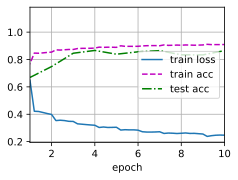

In [12]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())


In [13]:
net[1].gamma.reshape((-1, )), net[1].beta.reshape((-1, ))

(tensor([2.0889, 1.5921, 2.2956, 1.5194, 1.5850, 1.4149], device='cuda:0',
        grad_fn=<ViewBackward>),
 tensor([ 0.7274, -1.9263, -2.2282, -0.1798,  0.1889, -0.3067], device='cuda:0',
        grad_fn=<ViewBackward>))

In [20]:
"""简洁实现"""
# 应用BatchNorm与LeNet模型
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), 
    nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), 
    nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16*4*4, 120),
    nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), 
    nn.BatchNorm1d(84),
    nn.Sigmoid(), nn.Linear(84, 10)
)


loss 0.252, train acc 0.908, test acc 0.827
51794.6 examples/sec on cuda:0


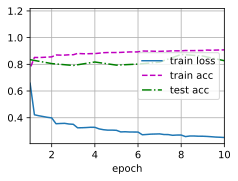

In [21]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())
